# Temperature Analysis 2040 Forecast - Israel

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('tas_1901_2016_ISR.csv')

In [3]:
df.head()

Temperature - (Celsius)   Year    Statistics  Country  ISO3
0                   9.6809   1901   Jan Average   Israel   ISR
1                  15.0439   1901   Feb Average   Israel   ISR
2                  16.7962   1901   Mar Average   Israel   ISR
3                  18.0111   1901   Apr Average   Israel   ISR
4                  18.8765   1901   May Average   Israel   ISR

## Data Preparation:

In [4]:
months = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

df['Month'] = df[' Statistics'].apply(lambda x: x[1:4])
df['Month'] = df['Month'].map(months)

In [5]:
df.drop([' Statistics', ' Country', ' ISO3'], axis=1, inplace=True)

In [6]:
df.columns = ['Temperature', 'Year', 'Month']

In [7]:
df.index = pd.date_range(start='1901-01-01', end='2017-01-01', freq='M')

## EDA:

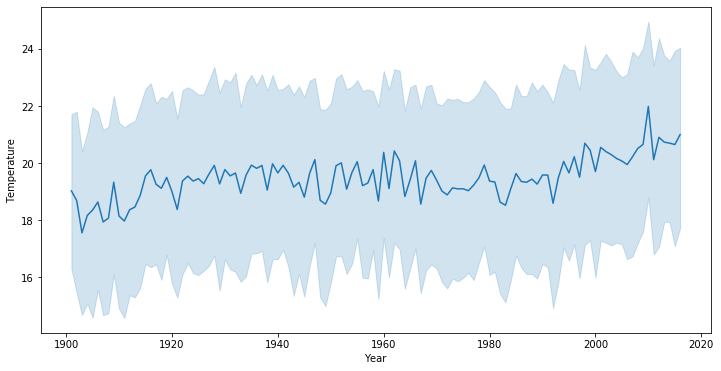

In [8]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='Year', y='Temperature');

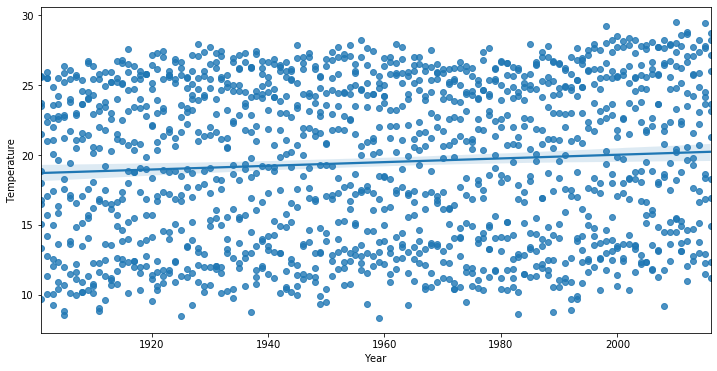

In [9]:
plt.figure(figsize=(12,6))
sns.regplot(data=df, x='Year', y='Temperature');

In [10]:
df_pivot = df.pivot('Month', 'Year', 'Temperature')

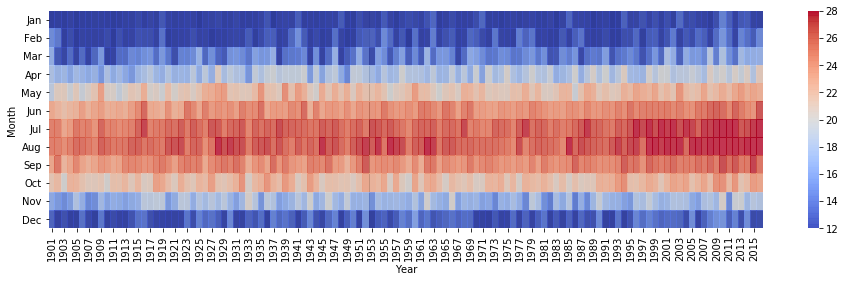

In [11]:
plt.figure(figsize=(16,4))
sns.heatmap(df_pivot, cmap='gist_gray', cbar=False, linecolor='black', linewidths=0.005)
sns.heatmap(df_pivot, cmap='coolwarm', vmin=12, vmax=28, alpha=0.8,
            yticklabels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']);

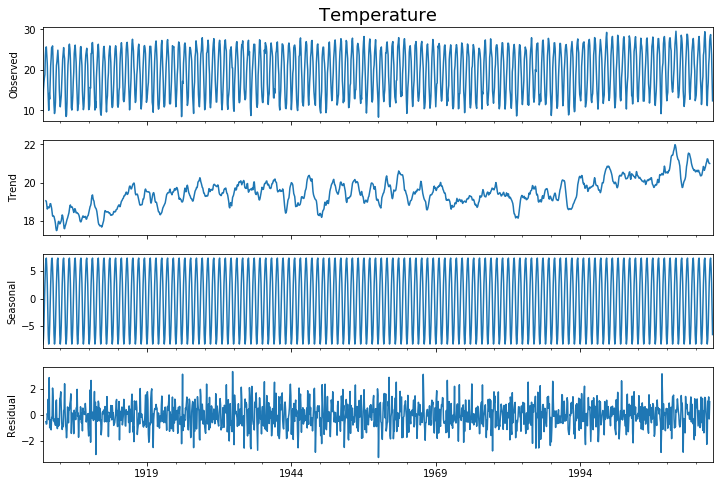

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['Temperature'], model='additive')

fig, axes = plt.subplots(4, 1, sharex=True)
fig.set_size_inches(12,8) 
axes[0].set_title('Temperature', fontsize=18)

decompose.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
decompose.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
decompose.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decompose.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual');

Exploring the p,d,q parameters:

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs

def stationarity_analyzer(data, n_diff, diff=None, n_seasonality=None, figsize=None):
    '''
    Description
    ==================================================
    Efficient procedure to choose the (p,d,q) and (P,D,Q) parameters, including guidance.


    Inputs
    ==================================================
    data: data input, in pandas DataFrame or Series format.
    n_diff: how many steps of differencing will be done.
    diff: define the optimal n_diff, if None, it will be decided by pmdarima ndiffs function.
    n_seasonality: define the lag for each difference, for seasonal differencing (after how many seasons the cycle ends).
    figsize: adjust the plots width and height.


    Guidance
    ==================================================
    A) Dealing with ARIMA models:

        "I" component (d):
        The right order of differencing is the minimum differencing required to get a near-stationary series.
        If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing.
        On the other hand, if the lag 1 (numbered 1 on the plot) autocorrelation is too negative, then the series is probably over-differenced.

        "AR" component (p):
        Choose the first line in the PACF plot who is significant (above the significance line), exclude the zero line (the first on the plot).

        "MA" component (q):
        Choose the first line in the ACF plot who is significant (above the significance line), exclude the zero line (the first on the plot).


    B) Dealing with SARIMA models:
        1) Follow the same procedure as for ARIMA model to choose the (p,d,q) parameters.

        2) Then, if the time series has seasonality, run the same procedure again to choose (P,D,Q) parameters.
        But this time, enter the currect number of seasons (n_seasons parameter) to define the seasonality.
        e.g.: monthly(12), quarterly (3), etc (if the series index has monthly frequency).
        Then, use it as the forth paramter for SARIMA: (P,D,Q)[S], when the S parameter stands for the n_seasonality value.

    C) Final adjustments:
        *** If the series is slightly under-differenced, try to add one or more "AR" terms.
        *** Likewise, if the series is slightly over-differenced, try to add one or more "MA" terms.


    Created by Roei Arpaly, 2021. linkedin.com/in/roei-arpaly.
    '''

    if figsize == None:
        figsize = (14, 8+n_diff*3)
    
    if n_seasonality == None:
        n_seasonality = 1

    if (type(data) is not pd.DataFrame) and (type(data) is not pd.Series):
        raise ValueError("INSERT PANDAS DATAFRAME / SERIES")



    fig, axes = plt.subplots(n_diff+2, 2, figsize=figsize)
    order_dict = {1:'st', 2:'nd', 3:'rd'}
    df = data


    ## "I" component (d):

    for i in range(n_diff+1):
        test = adfuller(df.dropna().values)
        title = f'{str(i)}th Order Differencing (n_seasonality: {n_seasonality})\nAugmented Dickey Fuller test:\nP-Value: {round(test[1], 2)}, Statistic: {round(test[0], 2)}'
        pacf_title = f'{str(i)}th Order Differencing Autocorrelation'

        if i == 0: # Original Series
            title = f'Original Series\nAugmented Dickey Fuller test:\nP-Value: {round(test[1], 2)}, Statistic: {round(test[0], 2)}'
            pacf_title = 'Original Autocorrelation'
        if 0 < i < 3:
            title = f'{str(i)+order_dict[i]} Order Differencing (n_seasonality: {n_seasonality})\nAugmented Dickey Fuller test:\nP-Value: {round(test[1], 2)}, Statistic: {round(test[0], 2)}'
            pacf_title = f'{str(i)+order_dict[i]} Order Differencing Autocorrelation'

        axes[i, 0].plot(df.values, zorder=0)
        axes[i, 0].set_title(title)
        axes[i, 0].hlines(df.mean(), 0, len(df), colors='red', label='Mean', zorder=1)
        axes[i, 0].hlines(df.median(), 0, len(df), colors='k', linestyle='--', label='Median', zorder=2)
        plot_acf(df.diff().dropna().values, ax=axes[i, 1], title=pacf_title)
        
        axes[i, 0].legend(loc=1)
        
        df = df.diff(n_seasonality)

    ## "AR" component (p):

    if diff == None:
        diff = ndiffs(data, test='adf')

    for j in range(diff):
        data = data.diff(n_seasonality)
        
    plot_pacf(data.dropna().values, ax=axes[i+1, 0], title=f"PACF - Partial Autocorrelation of {diff} differencing (choose p)");
    axes[i+1, 0].set(ylim=(0, None))


    ## "MA" component (q):

    plot_acf(data.dropna().values, ax=axes[i+1, 1], title=f"ACF - Autocorrelation of {diff} differencing (choose q)");
    axes[i+1, 1].set(ylim=(0, None))

    plt.tight_layout();

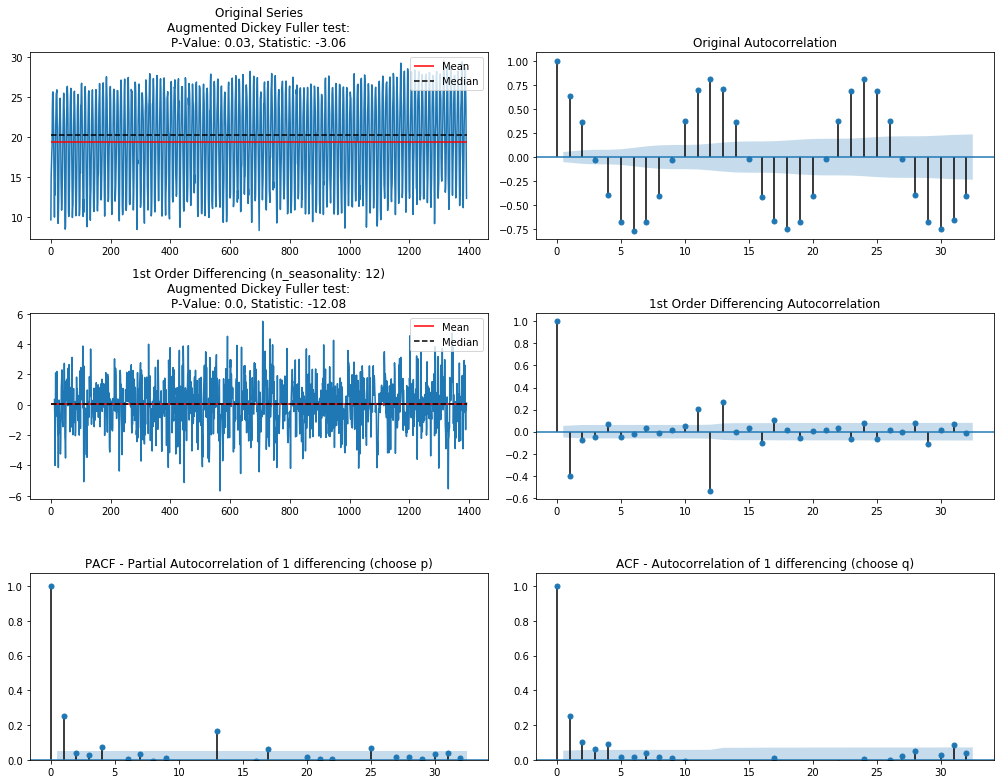

In [14]:
stationarity_analyzer(df['Temperature'], n_diff=1, diff=1, n_seasonality=12)

## Comparing TimeSeries Models:

Split the data into train-test:

In [15]:
test_length = 5*12 # 5 years.
train = df['Temperature'][:-test_length]
test = df['Temperature'][-test_length:]

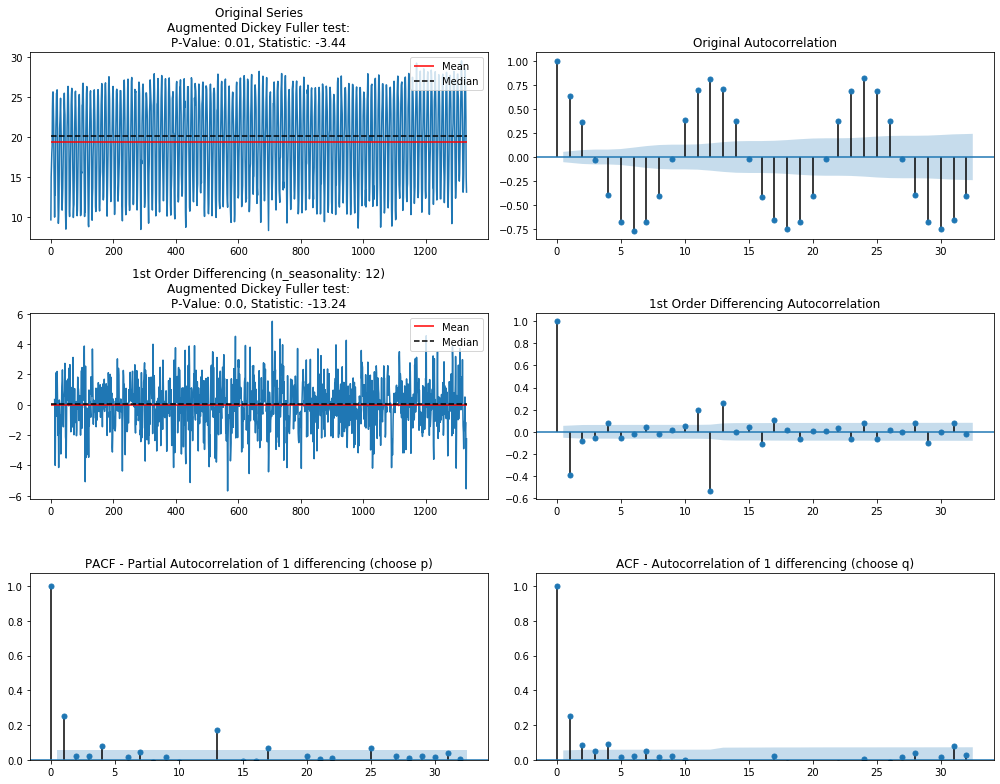

In [16]:
stationarity_analyzer(train, n_diff=1, diff=1, n_seasonality=12)

#### Testing various algorithms:

*   Holt-Winters Triple Exponential Smoothing
*   Error-Trend-Seasonality model (ETS)
*   Prophet (by facebook)
*   Seasonal-Auto-Regressive-Integrated-Moving-Average model (SARIMA)
*   Long Short Term Memory deep-learning model (LSTM)

C:\Users\ronis\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ronis\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


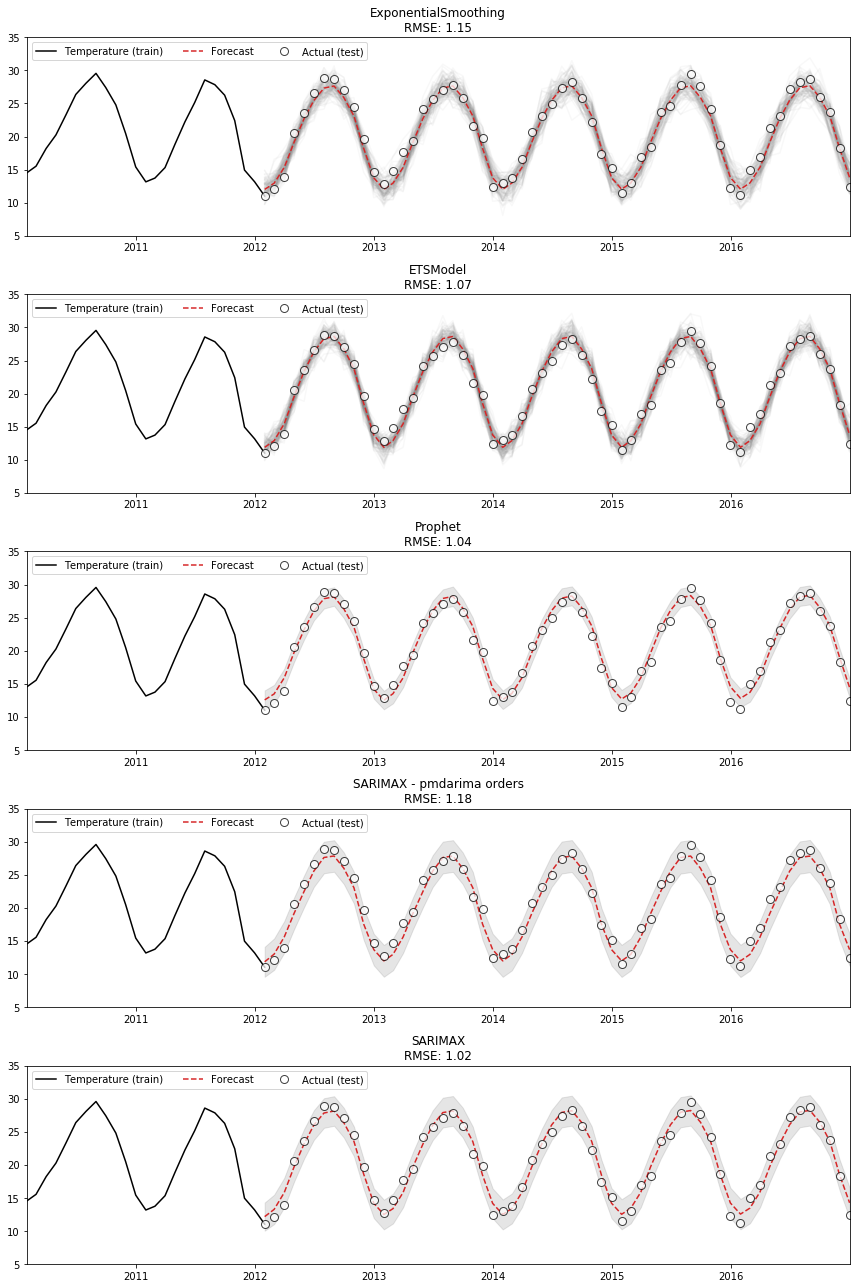

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from fbprophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import pmdarima as pm

auto_model = pm.auto_arima(train, seasonal=True, m=12, error_action="ignore", trace=False)


plot_train_range = train[12*109:].append(test[:1])
n_periods = len(test)



models = [
        ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12, initialization_method='estimated'),
        ETSModel(train, error='add', trend=None, seasonal='mul', seasonal_periods=12, initialization_method='estimated'),
        Prophet(weekly_seasonality=False, daily_seasonality=False),
        SARIMAX(train, order=auto_model.order, seasonal_order=auto_model.seasonal_order, freq='M'),
        SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12), freq='M') # Hand picked by analyzing the stationarity with the "stationarity_analyzer".
        ]

fig, axes = plt.subplots(len(models), 1, figsize=(12,18))

pmdarima_orders = True
counter = 0
for model in models:
    title = ''

    if type(model) is Prophet:
        df_prop = pd.DataFrame({'ds':train.index, 'y':train.values})
        model.fit(df_prop)
        future = model.make_future_dataframe(periods=n_periods, freq='M')
        summary = model.predict(future).set_index('ds')[12*111:]
        fcast = summary['yhat']
        lower_bound = summary['yhat_lower']
        upper_bound = summary['yhat_upper']

    elif type(model) is SARIMAX:
        fitted_model = model.fit(maxiter=200, disp=False)
        
        if pmdarima_orders == True:
            title = ' - pmdarima orders'
        pmdarima_orders = False
        
        summary = fitted_model.get_forecast(n_periods).summary_frame(alpha=0.05) # 95% confidence
        fcast = summary['mean']
        lower_bound = summary['mean_ci_lower']
        upper_bound = summary['mean_ci_upper']

    else:
        anchor = None
        if type(model) is ETSModel:
            anchor = 'end'
            # summary = fitted_model.get_prediction(start=fcast.index.min(), end=fcast.index.max()).summary_frame(alpha=0.05) # summary (for ETS only).

        fitted_model = model.fit()
        fcast = fitted_model.forecast(n_periods)
        
        simulations = fitted_model.simulate(n_periods, repetitions=100, anchor=anchor) # Instead of confidence interval.
        # Convert to lower and upper bound with: lower_bound = simulations.transpose().quantile(0.95)
        #                                        upper_bound = simulations.transpose().quantile(0.05)
        axes[counter].plot(simulations, alpha=0.05, color='grey', zorder=0)

    axes[counter].plot(plot_train_range, label='Temperature (train)', color='k')
    axes[counter].plot(fcast, label='Forecast', color='tab:red', linestyle='--', zorder=1)
    axes[counter].plot(test, label='Actual (test)', color='white', marker='o', markeredgecolor='k', markersize=8, linestyle='None', alpha=0.75)
    axes[counter].set_title(f'{model.__class__.__name__+title}\nRMSE: {round(np.sqrt(mean_squared_error(test, fcast)), 2)}')
    axes[counter].set_xlim(plot_train_range.index.min(), fcast.index.max())
    axes[counter].set_ylim(5,35)

    if type(model) in [Prophet, SARIMAX]:
        axes[counter].fill_between(fcast.index, upper_bound, lower_bound, alpha=0.2, linewidth=1, edgecolor='k', color='tab:grey')

    axes[counter].legend(loc=2, ncol=3)
    counter += 1

plt.tight_layout()

##### LSTM

In [18]:
train = pd.DataFrame(train)
test = pd.DataFrame(test)

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [20]:
from keras.preprocessing.sequence import TimeseriesGenerator

batch_length = 12*4 # length of 4 and half years to predict the next 1 month. can't be larger then the test length.
batch_size = 1

generator = TimeseriesGenerator(scaled_train, scaled_train, length=batch_length, batch_size=batch_size)
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=batch_length, batch_size=batch_size)

In [21]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


n_features = 1 # Increase only in multivariate situation.

model = Sequential()
model.add(LSTM(96, activation='relu', input_shape=(batch_length, n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 96)                37632     
_________________________________________________________________
dense (Dense)                (None, 1)                 97        
Total params: 37,729
Trainable params: 37,729
Non-trainable params: 0
_________________________________________________________________


In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True) # Stop after 15 epochs with no improvement.

In [23]:
# import os
import random
import tensorflow as tf

seed = 276

# os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)


model.fit(generator, epochs=50, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/50
1284/1284 [==============================] - 15s 12ms/step - loss: 0.0378 - val_loss: 0.0091
Epoch 2/50
1284/1284 [==============================] - 14s 11ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 3/50
1284/1284 [==============================] - ETA: 0s - loss: 0.0044- ETA: 0s - loss - 14s 11ms/step - loss: 0.0044 - val_loss: 0.0089
Epoch 4/50
1284/1284 [==============================] - 14s 11ms/step - loss: 0.0042 - val_loss: 0.0079
Epoch 5/50
1284/1284 [==============================] - 14s 11ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 6/50
1284/1284 [==============================] - 14s 11ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 7/50
1284/1284 [==============================] - 15s 12ms/step - loss: 0.0041 - val_loss: 0.0051
Epoch 8/50
1284/1284 [==============================] - 14s 11ms/step - loss: 0.0039 - val_loss: 0.0056
Epoch 9/50
1284/1284 [==============================] - 14s 11ms/step - loss: 0.0039 - val_loss: 0.0074
Epoch 10/50
1284/1284 [

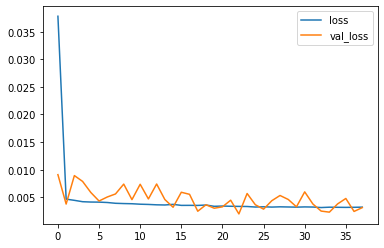

In [24]:
losses = pd.DataFrame(model.history.history)
losses.plot();

In [25]:
test_predictions = []

first_eval_batch = scaled_train[-batch_length:]
current_batch = first_eval_batch.reshape((1, batch_length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred)
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

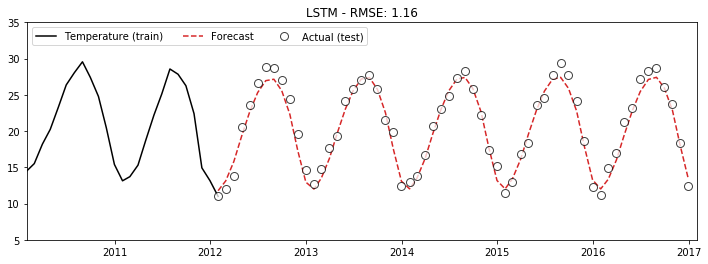

In [26]:
true_predictions = scaler.inverse_transform(test_predictions)
fcast = pd.DataFrame(true_predictions.reshape(-1), index=test.index, columns=['Forecast'])

fig, axes = plt.subplots(figsize=(12,4))

axes.plot(plot_train_range, label='Temperature (train)', color='k')
axes.plot(fcast, label='Forecast', color='tab:red', linestyle='--', zorder=1)
axes.plot(test, label='Actual (test)', color='white',
          marker='o', markeredgecolor='k', markersize=8, linestyle='None', alpha=0.75)

axes.set_title(f"LSTM - RMSE: {round(np.sqrt(mean_squared_error(test, fcast)), 2)}")
axes.set_xlim(plot_train_range.index.min(), fcast.index.max()+pd.DateOffset(months=1)), axes.set_ylim(5,35)
axes.legend(loc=2, ncol=3);

In [27]:
model.save_weights('lstm_model.h5')

## CO2 Emissions (dealing with exogenous variable)

In [28]:
co2_emissions = pd.read_csv('GCB2020v18_MtCO2_flat.csv', encoding="ISO-8859-1")

In [29]:
co2_emissions['Fossils fuel & Cement'] = co2_emissions['Coal'] + co2_emissions['Cement']

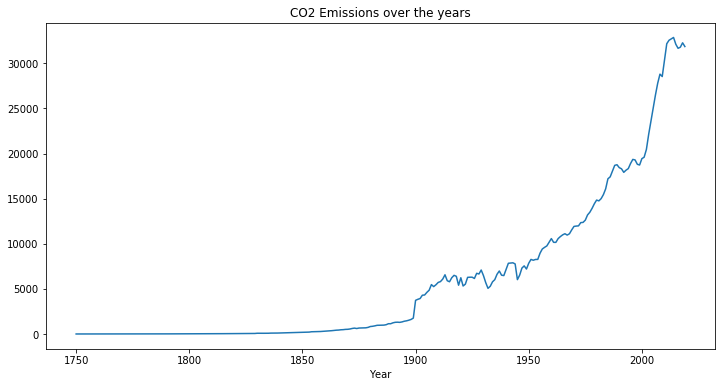

In [30]:
co2_emissions.groupby('Year').sum()['Fossils fuel & Cement'].plot(figsize=(12,6), title='CO2 Emissions over the years');

In [31]:
co2_df = co2_emissions.groupby('Year').sum()['Fossils fuel & Cement'][-119:]
co2_df.index = pd.to_datetime(co2_df.index, format='%Y')
co2_df.index.freq = 'YS'

In [32]:
df_10year = df['Temperature'].rolling(12*10).mean().dropna()
df_10year_mean = df_10year.resample(rule='A').mean()
df_10year_mean.index = pd.to_datetime(df_10year_mean.index.year, format='%Y')

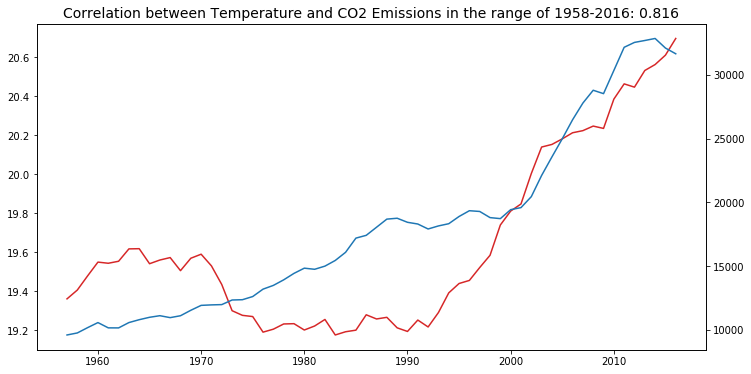

In [33]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot()
ax1.plot(df_10year_mean[-60:], color='tab:red')

ax2 = plt.twinx()
ax2.plot(co2_df[-63:-3])
plt.title(f"Correlation between Temperature and CO2 Emissions in the range of 1958-2016: {round(np.corrcoef(df_10year_mean[-60:].values, co2_df[-63:-3].values).min(), 3)}", fontsize=14);

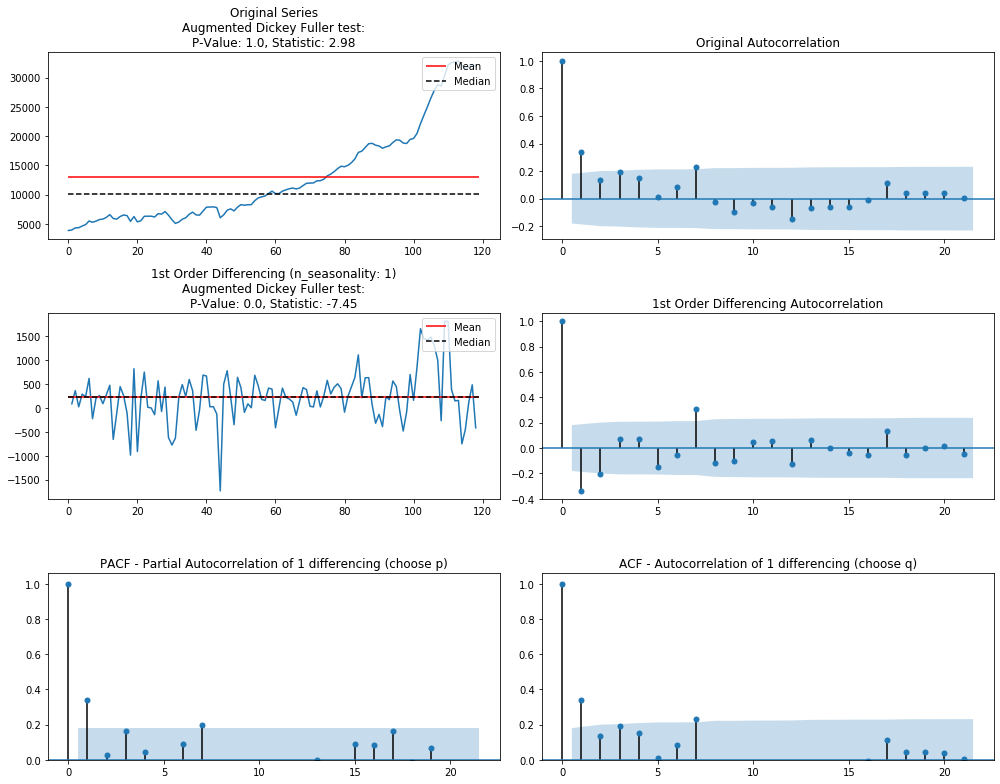

In [34]:
stationarity_analyzer(co2_df, n_diff=1)

In [35]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(co2_df, order=(1,1,1), freq='YS')
fitted_model = model.fit()

In [36]:
n_periods = 22

fcast_summary = fitted_model.get_forecast(n_periods).summary_frame()

df_co2_comb = pd.concat([pd.concat([co2_df, fcast_summary['mean']], axis=0), fcast_summary[['mean_ci_lower','mean_ci_upper']]], axis=1)
df_co2_comb.columns

Index([0, 'mean_ci_lower', 'mean_ci_upper'], dtype='object')

In [37]:
df_co2_comb.columns = ['CO2', 'Lower Bound', 'Upper Bound']

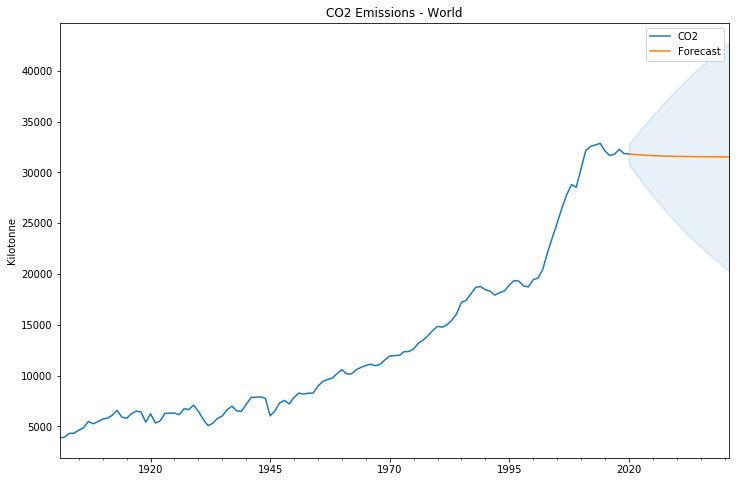

In [38]:
forecast_index = df_co2_comb['Lower Bound'].first_valid_index()
df_co2_comb['CO2'][:forecast_index].plot(figsize=(12,8), title='CO2 Emissions - World', legend=True)
df_co2_comb['CO2'][forecast_index:].plot(legend=True, label='Forecast')

plt.fill_between(df_co2_comb.index, df_co2_comb['Upper Bound'], df_co2_comb['Lower Bound'], alpha=0.1, linewidth=2, color='tab:blue')
plt.ylabel('Kilotonne');

In [39]:
df_co2_comb['Lower Bound'][forecast_index-pd.DateOffset(years=4):forecast_index-pd.DateOffset(years=1)].fillna(df_co2_comb['CO2'], inplace=True)
df_co2_comb['Upper Bound'][forecast_index-pd.DateOffset(years=4):forecast_index-pd.DateOffset(years=1)].fillna(df_co2_comb['CO2'], inplace=True)

### Using the CO2 Forecast as exogenous variable:

Adjusting the CO2 to monthly frequency (assuming linearity):

In [40]:
monthly_co2 = []

for i in range(len(co2_df)-1):
    monthly_co2.extend(np.linspace(co2_df.iloc[i], co2_df.iloc[i+1], 12, endpoint=False))

exog_train = monthly_co2[:-7*12]
exog_test = monthly_co2[-7*12:-2*12]

In [41]:
train = df['Temperature'][:-5*12]
test = df['Temperature'][-5*12:]

In [42]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train, exog=exog_train, order=(1,1,1), seasonal_order=(1,1,1,12), freq='M')
fitted_model = model.fit(maxiter=200, disp=False)

fcast_summary = fitted_model.get_forecast(len(test), exog=exog_test).summary_frame(alpha=0.05) # 95% confidence
print(fitted_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        Temperature   No. Observations:                 1332
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2001.553
Date:                            Tue, 02 Mar 2021   AIC                           4015.106
Time:                                    22:41:15   BIC                           4046.214
Sample:                                01-31-1901   HQIC                          4026.769
                                     - 12-31-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3.768e-05   4.68e-05      0.805      0.421   -5.41e-05       0.000
ar.L1          0.2667      0.027   

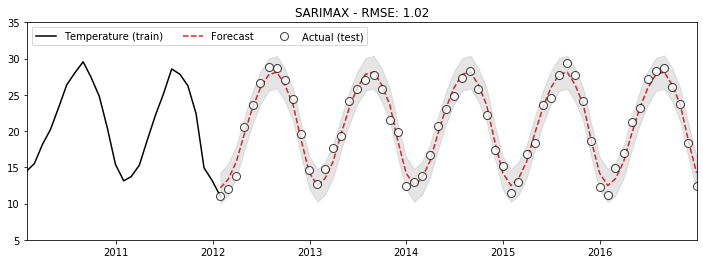

In [43]:
fig, axes = plt.subplots(figsize=(12,4))

axes.plot(plot_train_range, label='Temperature (train)', color='k')
axes.plot(fcast_summary['mean'], label='Forecast', color='tab:red', linestyle='--', zorder=1)
axes.plot(test, label='Actual (test)', color='white',
          marker='o', markeredgecolor='k', markersize=8, linestyle='None', alpha=0.75)

axes.fill_between(fcast.index, fcast_summary['mean_ci_upper'], fcast_summary['mean_ci_lower'],
                  alpha=0.2, linewidth=1, edgecolor='k', color='tab:grey')

axes.set_title(f"SARIMAX - RMSE: {round(np.sqrt(mean_squared_error(test, fcast_summary['mean'])), 2)}")
axes.set_xlim(plot_train_range.index.min(), fcast_summary.index.max()), axes.set_ylim(5,35)
axes.legend(loc=2, ncol=3);

Splitting the CO2 forecast to lower, flat and upper projections.

In [44]:
df_co2_pred = df_co2_comb.dropna()

monthly_co2_mid = []
monthly_co2_low = []
monthly_co2_high = []

for i in range(len(df_co2_pred['CO2'])-1):
    monthly_co2_mid.extend(np.linspace(df_co2_pred['CO2'].iloc[i], df_co2_pred['CO2'].iloc[i+1], 12, endpoint=False))
    monthly_co2_low.extend(np.linspace(df_co2_pred['Lower Bound'].iloc[i], df_co2_pred['Lower Bound'].iloc[i+1], 12, endpoint=False))
    monthly_co2_high.extend(np.linspace(df_co2_pred['Upper Bound'].iloc[i], df_co2_pred['Upper Bound'].iloc[i+1], 12, endpoint=False))

Forecasting 25 years forward based on the 3 scenarios of the exogenous variable.

In [45]:
monthly_co2_past = []

for i in range(len(co2_df)-1):
    monthly_co2_past.extend(np.linspace(co2_df.iloc[i], co2_df.iloc[i+1], 12, endpoint=False))

exog_past = monthly_co2_past[:-2*12] #Discluding 2017-2019.

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

n_periods = 25*12 #25 years.

exog_past = exog_past

model = SARIMAX(df['Temperature'], exog=exog_past, order=(1,1,1), seasonal_order=(1,1,1,12))
fitted_model = model.fit(maxiter=100, disp=False)

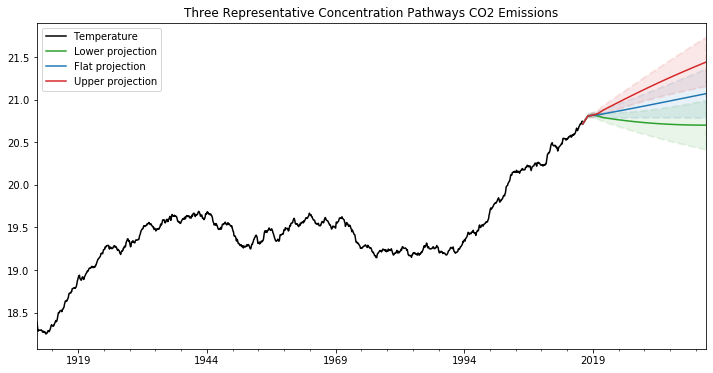

In [47]:
df_10year.plot(figsize=(12,6), legend=True, color='k',
               title='Three Representative Concentration Pathways CO2 Emissions')

projections = [monthly_co2_low , monthly_co2_mid, monthly_co2_high]
colors = {'Lower projection':'tab:green', 'Flat projection':'tab:blue', 'Upper projection':'tab:red'}

for i in range(len(projections)):
    model = fitted_model.get_forecast(n_periods, exog=projections[i]).summary_frame(alpha=0.15)
    summary = model.resample(rule='AS').mean()
    summary['mean_ci_lower'] += (summary['mean'][0] - summary['mean_ci_lower'][0])
    summary['mean_ci_upper'] += (summary['mean'][0] - summary['mean_ci_upper'][0])
    
    summary['mean'].plot(color=list(colors.values())[i], label=list(colors.keys())[i], legend=True)
    plt.fill_between(summary.index, summary['mean_ci_upper'], summary['mean_ci_lower'],
                     alpha=0.1, linewidth=2, linestyle='--', color=list(colors.values())[i])

## Seasonal Prediction

In [48]:
import pmdarima as pm

auto_model = pm.auto_arima(df['Temperature'], seasonal=True, m=12, error_action="ignore", trace=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=5.19 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7205.244, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6406.086, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7203.244, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6725.600, Time=0.18 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=2.06 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=6095.588, Time=2.89 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=8.43 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=6131.489, Time=0.93 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=6067.255, Time=1.67 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=6303.308, Time=0.63 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=7.74 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=3.89 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=6074.9

### Prediction with pmdarima:

In [49]:
# Prediction with pmdarima:
n_periods = 12*25 #25 years

start = df.index[-1] + pd.DateOffset(months=1)
end = df.index[-1] + pd.DateOffset(months=n_periods)

index = pd.date_range(start=start, end=end, freq='M')
data = auto_model.predict(n_periods=n_periods)

fcastpmd = pd.Series(index=index, data=data).rename(f'SARIMA{auto_model.order}{auto_model.seasonal_order} Forecast PM')

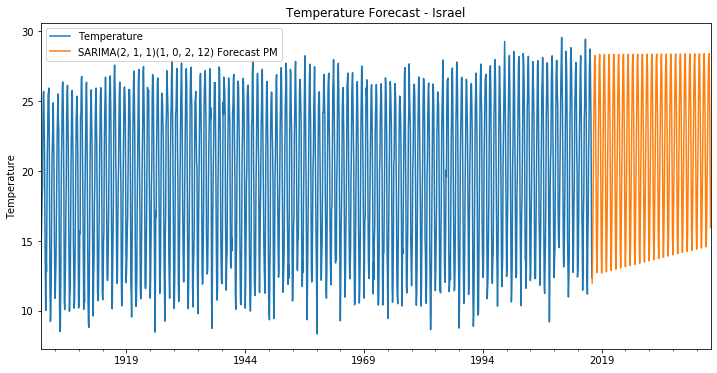

In [50]:
df['Temperature'].plot(figsize=(12,6), title='Temperature Forecast - Israel', legend=True)
fcastpmd.plot(legend=True)
plt.ylabel('Temperature');

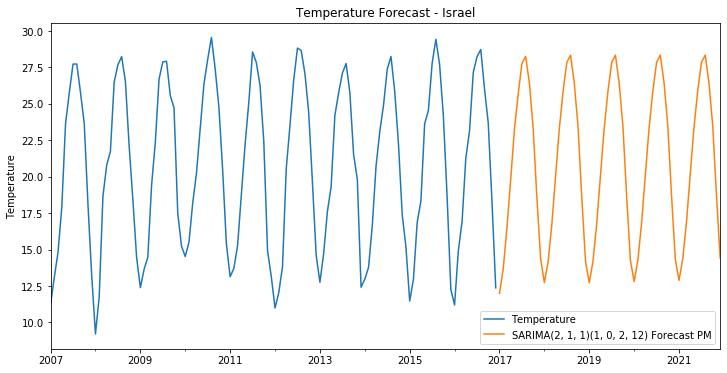

In [51]:
df['Temperature'][-120:].plot(figsize=(12,6), title='Temperature Forecast - Israel', legend=True)
fcastpmd[-n_periods:-12*20].plot(legend=True)
plt.ylabel('Temperature');

### Prediction with statsmodels (SARIMAX):

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df['Temperature'], order=auto_model.order, seasonal_order=auto_model.seasonal_order, freq='M')
fitted_model = model.fit(maxiter=200, disp=False)

print(fitted_model.summary())

C:\Users\ronis\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ronis\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ronis\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                        SARIMAX Results                                        
Dep. Variable:                             Temperature   No. Observations:                 1392
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood               -2147.609
Date:                                 Tue, 02 Mar 2021   AIC                           4309.218
Time:                                         22:44:03   BIC                           4345.883
Sample:                                     01-31-1901   HQIC                          4322.929
                                          - 12-31-2016                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3100      0.023     13.626      0.000       0.265       0

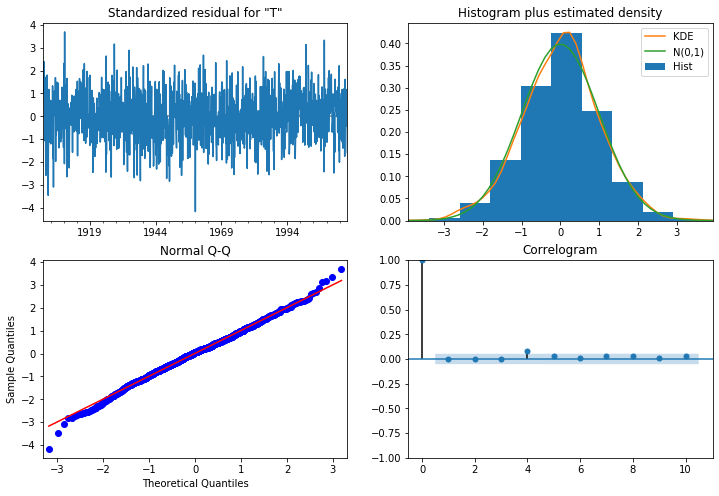

In [53]:
fitted_model.plot_diagnostics(figsize=(12,8));

In [54]:
n_periods = 12*25 #25 years

fcast_summary = fitted_model.get_forecast(n_periods).summary_frame(alpha=0.05) # 95% confidence

df_seasonal = pd.concat([pd.concat([df['Temperature'], fcast_summary['mean']], axis=0), fcast_summary[['mean_ci_lower','mean_ci_upper']]], axis=1)
df_seasonal.columns

Index([0, 'mean_ci_lower', 'mean_ci_upper'], dtype='object')

In [55]:
df_seasonal.columns = ['Temperature', 'Lower Bound', 'Upper Bound']

## For continuous line and confidence intervals:
# df_seasonal.loc['2016-12-31'][['Lower Bound', 'Upper Bound']] = df_seasonal.loc['2016-12-31']['Temperature']

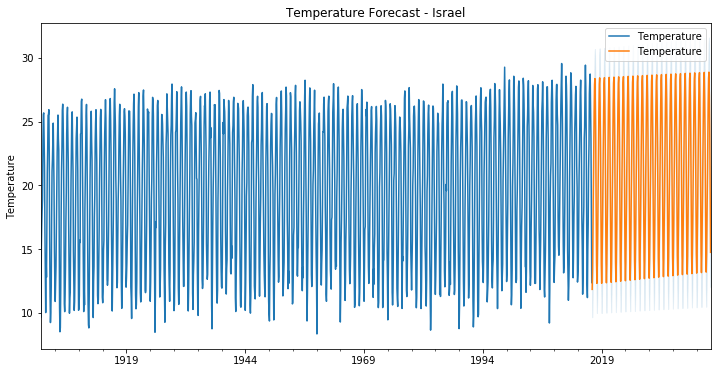

In [56]:
df_seasonal['Temperature'][:-n_periods].plot(figsize=(12,6), title='Temperature Forecast - Israel', legend=True)
df_seasonal['Temperature'][-n_periods:].plot(legend='Forecast')

plt.fill_between(df_seasonal.index, df_seasonal['Upper Bound'], df_seasonal['Lower Bound'], alpha=0.1, linewidth=1, edgecolor='k', color='tab:blue')
plt.ylabel('Temperature');

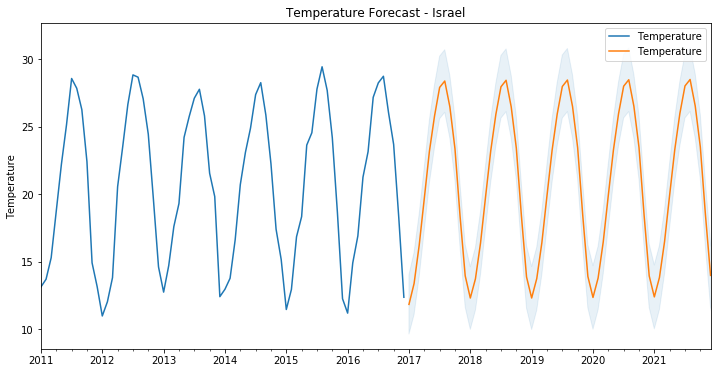

In [57]:
df_seasonal['Temperature'][12*110:-n_periods].plot(figsize=(12,6), title='Temperature Forecast - Israel', legend=True)
df_seasonal['Temperature'][-n_periods:-12*20].plot(legend='Forecast')

plt.fill_between(df_seasonal.index, df_seasonal['Upper Bound'], df_seasonal['Lower Bound'], alpha=0.1, linewidth=1, edgecolor='k', color='tab:blue')
plt.ylabel('Temperature');

In [58]:
fcast_summary = fcast_summary.resample(rule='AS').mean()

fcast_summary['mean_ci_lower'] += (fcast_summary['mean'][0] - fcast_summary['mean_ci_lower'][0])
fcast_summary['mean_ci_upper'] += (fcast_summary['mean'][0] - fcast_summary['mean_ci_upper'][0])

Adjust for trend forecasting:

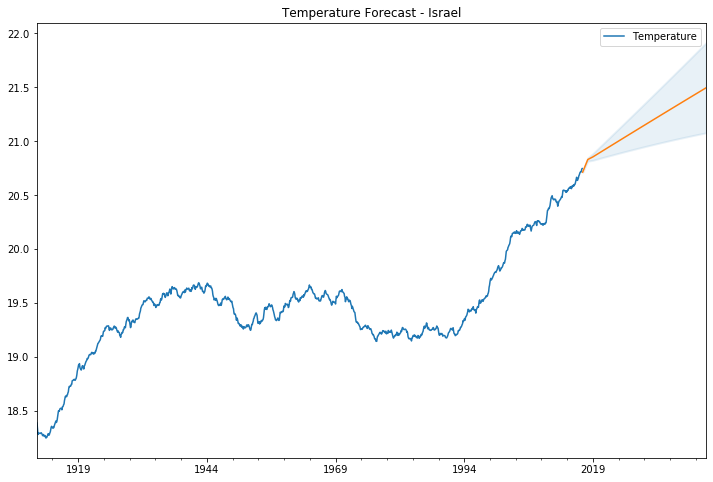

In [59]:
df['Temperature'].rolling(10*12).mean().dropna().plot(figsize=(12,8), title='Temperature Forecast - Israel', legend=True)

fcast_summary['mean'].plot()
plt.fill_between(fcast_summary.index, fcast_summary['mean_ci_upper'], fcast_summary['mean_ci_lower'], alpha=0.1, linewidth=2, color='tab:blue');

### Prediction with fbprophet:

In [60]:
from fbprophet import Prophet

In [61]:
df_prop = pd.DataFrame({'ds':df.index, 'y':df['Temperature'].values})

In [62]:
model = Prophet()
model.fit(df_prop)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [63]:
future = model.make_future_dataframe(periods=24, freq='M')
forecast = model.predict(future)

In [64]:
forecast.head(3)

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 1901-01-31  18.272734    8.426581   11.333202    18.272734    18.272734   
1 1901-02-28  18.276452    9.510085   12.276860    18.276452    18.276452   
2 1901-03-31  18.280568   11.853255   14.656948    18.280568    18.280568   

   additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
0       -8.401363             -8.401363             -8.401363 -8.401363   
1       -7.399167             -7.399167             -7.399167 -7.399167   
2       -5.007305             -5.007305             -5.007305 -5.007305   

   yearly_lower  yearly_upper  multiplicative_terms  \
0     -8.401363     -8.401363                   0.0   
1     -7.399167     -7.399167                   0.0   
2     -5.007305     -5.007305                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper       yhat  
0                         0.0                         0.0   9.871371  
1                         0.0                         0.0  10.877284  
2                         0.0                         0.0  13.273262

In [65]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

ds       yhat  yhat_lower  yhat_upper
1413 2018-10-31  23.902952   22.615940   25.447608
1414 2018-11-30  18.973157   17.528782   20.361385
1415 2018-12-31  14.531567   13.115200   15.925990

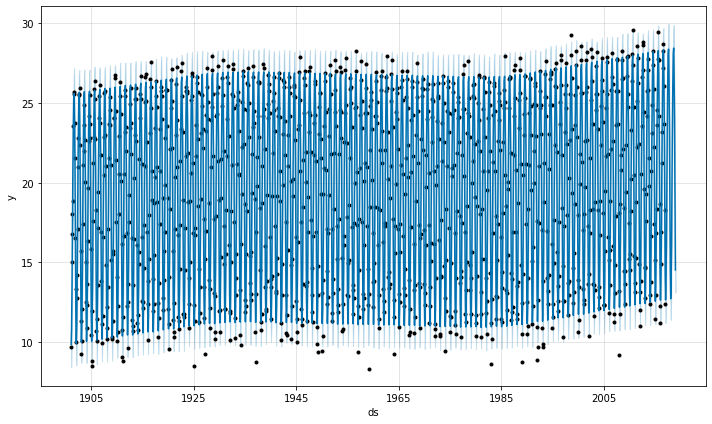

In [66]:
model.plot(forecast);

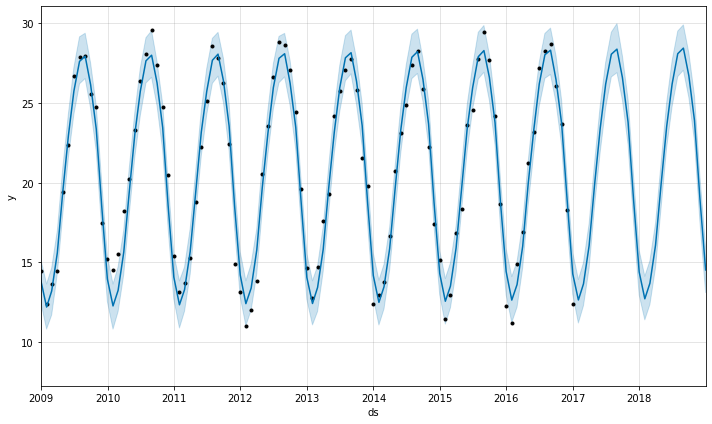

In [67]:
import matplotlib.dates as mdates

model.plot(forecast)
plt.xlim(mdates.date2num(forecast['ds'].max()-pd.DateOffset(months=12*10)), mdates.date2num(forecast['ds'].max()));

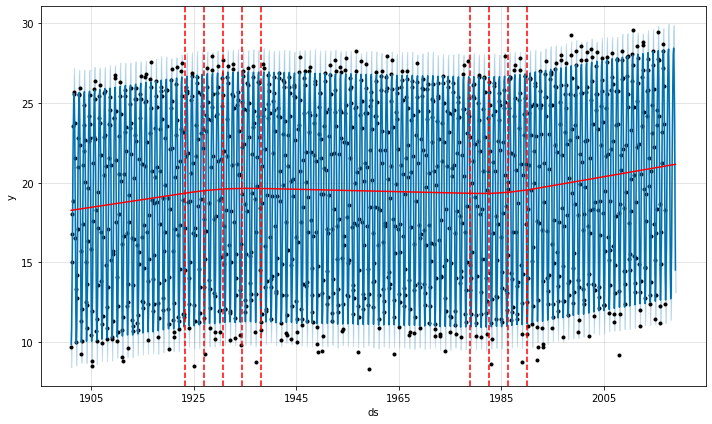

In [68]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)
add = add_changepoints_to_plot(fig.gca(), model, forecast);

### Prediction with statsmodels Holt-Winters' Triple Exponential Smoothing (TES):

In [69]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

n_periods = 12*25 #25 years

model =  ExponentialSmoothing(df['Temperature'], trend='add', seasonal='add', seasonal_periods=12, initialization_method='estimated')
model_fit = model.fit()

simulations = model_fit.simulate(n_periods, repetitions=100, error='mul')
fcast = model_fit.forecast(n_periods)

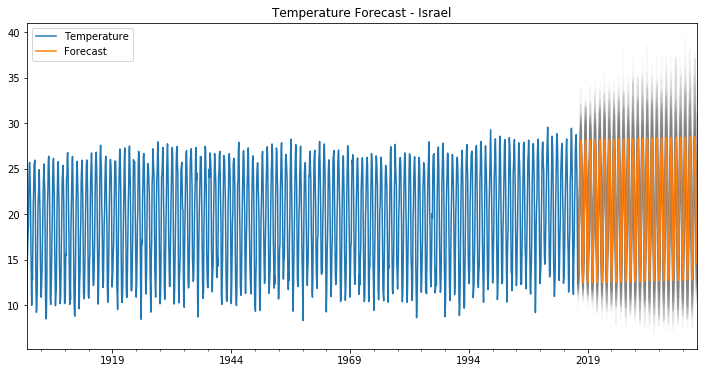

In [70]:
ax = df['Temperature'].plot(figsize=(12,6), title='Temperature Forecast - Israel', legend=True)

fcast.plot(ax=ax, label='Forecast', legend=True, zorder=1)
simulations.plot(ax=ax, alpha=0.05, color='grey', legend=False, zorder=0);

In [71]:
lower_bound = simulations.transpose().quantile(0.75)
upper_bound = simulations.transpose().quantile(0.25)

holts_df = pd.DataFrame({'Forecast': fcast, 'Lower Bound': lower_bound, 'Upper Bound': upper_bound}, index=simulations.index)

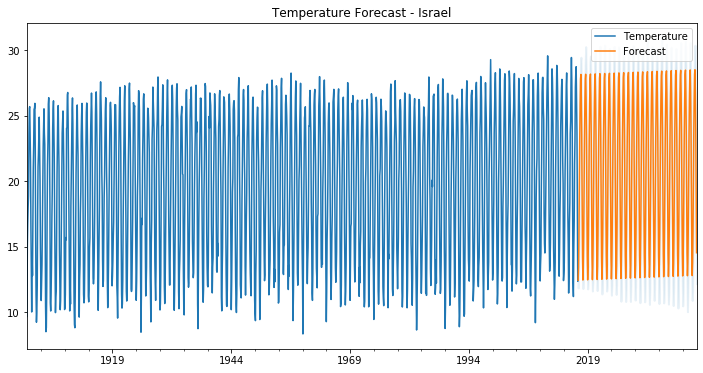

In [72]:
ax = df['Temperature'].plot(figsize=(12,6), title='Temperature Forecast - Israel', legend=True)

holts_df['Forecast'].plot(legend=True)
plt.fill_between(holts_df.index, holts_df['Upper Bound'], holts_df['Lower Bound'], alpha=0.1, linewidth=2, color='tab:blue');

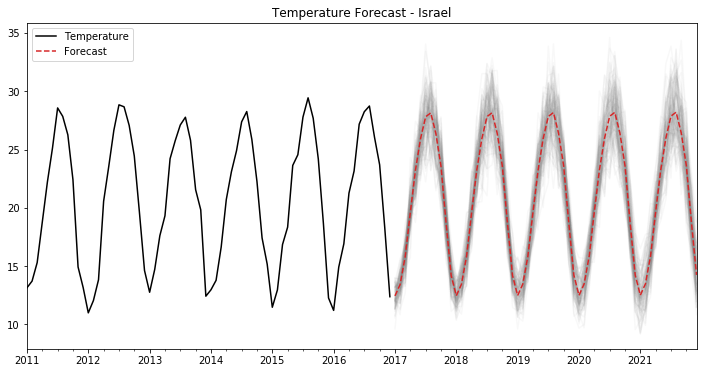

In [73]:
ax = df['Temperature'][12*110:].plot(figsize=(12,6), title='Temperature Forecast - Israel', color='k', legend=True)

fcast[:-12*20].plot(ax=ax, label='Forecast', color='tab:red', linestyle='--', legend=True, zorder=1)
simulations[:-12*20].plot(ax=ax, alpha=0.05, color='grey', legend=False, zorder=0);

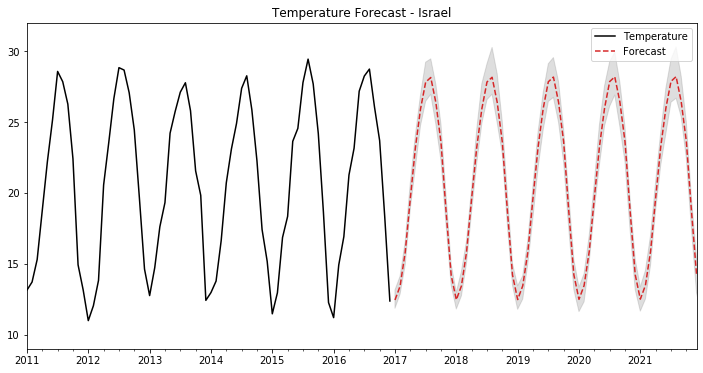

In [74]:
ax = df['Temperature'][12*110:].plot(figsize=(12,6), title='Temperature Forecast - Israel', color='k', legend=True)

fcast[:-12*20].plot(ax=ax, label='Forecast', color='tab:red', linestyle='--', legend=True, zorder=1)
plt.fill_between(holts_df.index, holts_df['Upper Bound'], holts_df['Lower Bound'], alpha=0.25, linewidth=1, color='tab:grey');

## 10 Year Moving Average Prediction:

#### Data Aggregation (ignoring seasonality) with 10 year moving average:

In [75]:
df_10year = df['Temperature'].rolling(12*10).mean().dropna()

In [76]:
import pmdarima as pm

auto_model = pm.auto_arima(df_10year, seasonal=False, m=1, error_action="ignore")
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1273
Model:               SARIMAX(1, 2, 1)   Log Likelihood                3765.504
Date:                Tue, 02 Mar 2021   AIC                          -7525.007
Time:                        22:44:22   BIC                          -7509.565
Sample:                             0   HQIC                         -7519.207
                               - 1273                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2539      0.026      9.737      0.000       0.203       0.305
ma.L1         -0.9834      0.006   -169.209      0.000      -0.995      -0.972
sigma2         0.0002   5.72e-06     27.268      0.0

### Prediction with statsmodels (ARIMA):

In [77]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_10year, order=(auto_model.order))
fitted_model = model.fit()


## SARIMAX Will work exactly the same.
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# model = SARIMAX(df_10year, order=auto_model.order, seasonal_order=auto_model.seasonal_order, freq='M')
# fitted_model = model.fit(maxiter=200, disp=False)

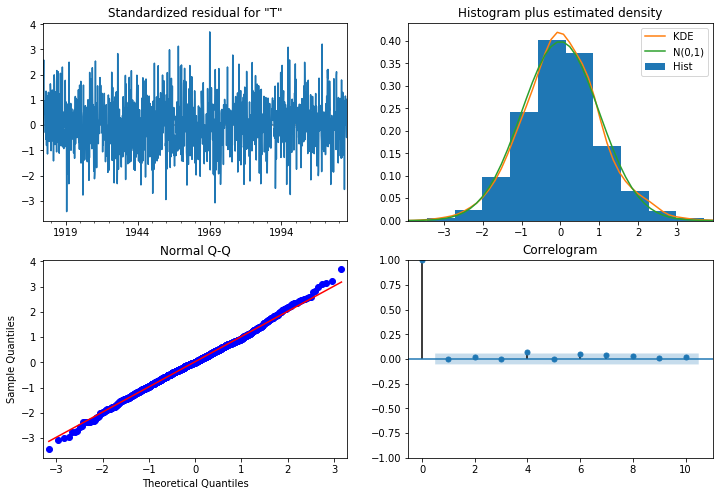

In [78]:
fitted_model.plot_diagnostics(figsize=(12,8));

In [79]:
n_periods = 12*25 #25 years

fcast_summary = fitted_model.get_forecast(n_periods).summary_frame()

df_trend = pd.concat([pd.concat([df_10year, fcast_summary['mean']], axis=0), fcast_summary[['mean_ci_lower','mean_ci_upper']]], axis=1)
df_trend.columns

Index([0, 'mean_ci_lower', 'mean_ci_upper'], dtype='object')

In [80]:
df_trend.columns = ['Temperature', 'Lower Bound', 'Upper Bound']

## For continuous line and confidence intervals:
# df_trend.loc['2016-12-31'][['Lower Bound', 'Upper Bound']] = df_trend.loc['2016-12-31']['Temperature']

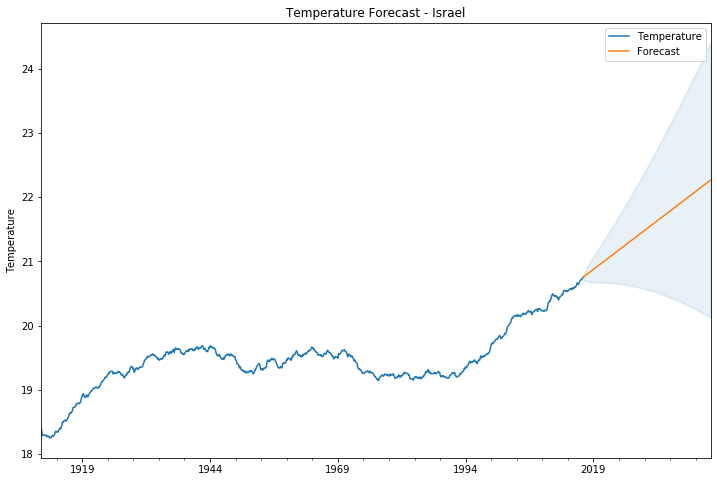

In [81]:
forecast_index = df_trend['Lower Bound'].first_valid_index()

df_trend['Temperature'][:forecast_index].plot(figsize=(12,8), title='Temperature Forecast - Israel', legend=True)
df_trend['Temperature'][forecast_index:].plot(legend=True, label='Forecast')

plt.fill_between(df_trend.index, df_trend['Upper Bound'], df_trend['Lower Bound'], alpha=0.1, linewidth=2, color='tab:blue')
plt.ylabel('Temperature');

### Prediction with fbprophet:

In [82]:
df_10year_prop = pd.DataFrame({'ds':df_10year.index, 'y':df_10year.values})

In [83]:
from fbprophet import Prophet

model = Prophet()
model.fit(df_10year_prop)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [84]:
n_periods = 12*25
future = model.make_future_dataframe(periods=n_periods, freq='M')
forecast = model.predict(future)

In [85]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
1568 2041-08-31  22.212333   20.303035   24.341450
1569 2041-09-30  22.216825   20.284316   24.336586
1570 2041-10-31  22.220712   20.273891   24.377507
1571 2041-11-30  22.225449   20.281410   24.377784
1572 2041-12-31  22.230309   20.290341   24.384138

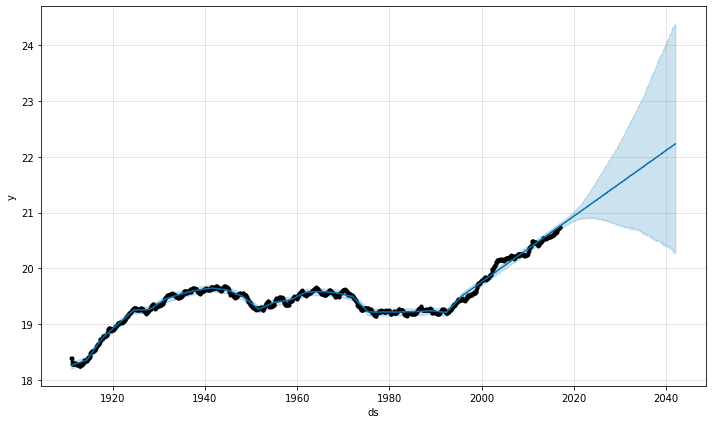

In [86]:
model.plot(forecast);

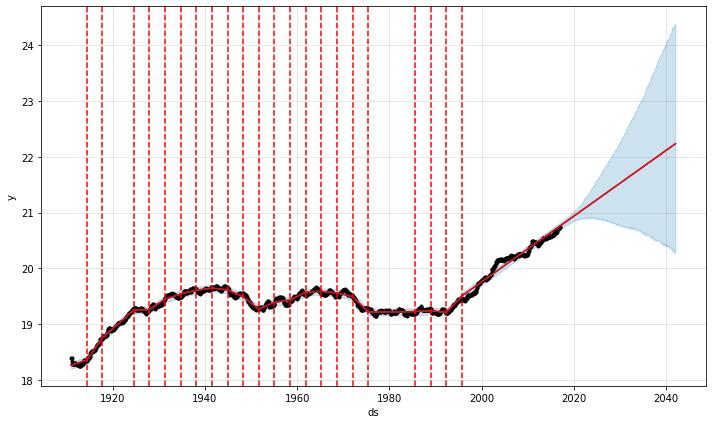

In [87]:
from fbprophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)
add = add_changepoints_to_plot(fig.gca(), model, forecast);

In [88]:
fcast_summary = forecast[-n_periods:][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
fcast_summary.set_index('ds', drop=True, inplace=True)

In [89]:
fcast_summary.head()

yhat  yhat_lower  yhat_upper
ds                                           
2017-01-31  20.759151   20.696901   20.819978
2017-02-28  20.769328   20.707935   20.831408
2017-03-31  20.773579   20.711705   20.835902
2017-04-30  20.777648   20.710619   20.838248
2017-05-31  20.782301   20.717824   20.846362

In [90]:
df_trend = pd.concat([pd.concat([df_10year, fcast_summary['yhat']], axis=0), fcast_summary[['yhat_lower','yhat_upper']]], axis=1)
df_trend.columns

Index([0, 'yhat_lower', 'yhat_upper'], dtype='object')

In [91]:
df_trend.columns = ['Temperature', 'Lower Bound', 'Upper Bound']

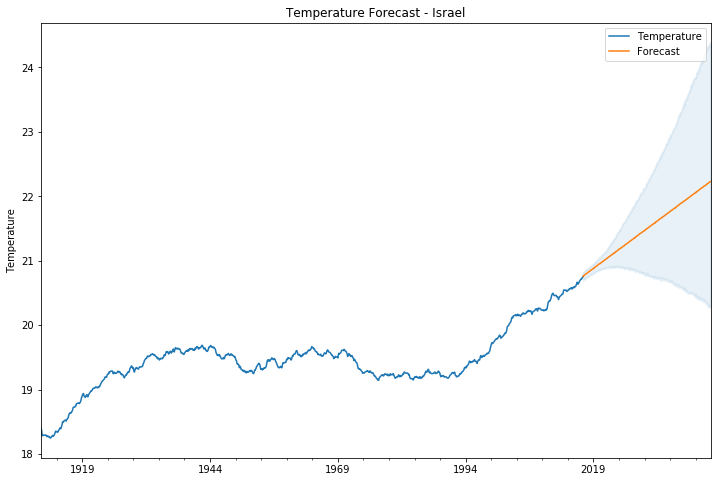

In [92]:
forecast_index = df_trend['Lower Bound'].first_valid_index()

df_trend['Temperature'][:forecast_index].plot(figsize=(12,8), title='Temperature Forecast - Israel', legend=True)
df_trend['Temperature'][forecast_index:].plot(legend=True, label='Forecast')

plt.fill_between(df_trend.index, df_trend['Upper Bound'], df_trend['Lower Bound'], alpha=0.1, linewidth=2, color='tab:blue')
plt.ylabel('Temperature');

### Prediction with statsmodels Holt-Winters' Triple Exponential Smoothing (TES):

In [93]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

n_periods = 12*25 #25 years

model =  ExponentialSmoothing(df_10year, trend='add', seasonal='add', seasonal_periods=None, initialization_method='estimated')
model_fit = model.fit()

simulations = model_fit.simulate(n_periods, repetitions=250, error='mul')
fcast = model_fit.forecast(n_periods)

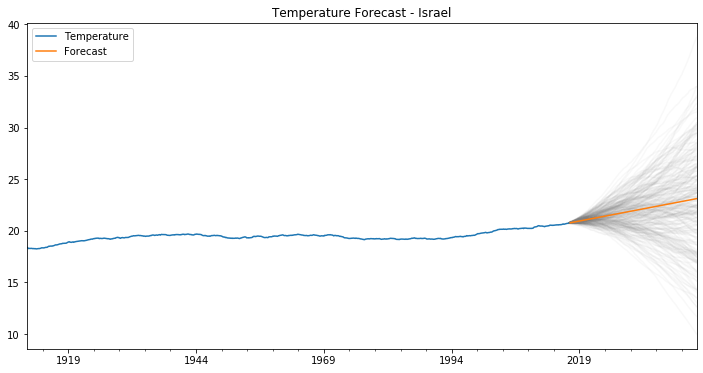

In [94]:
ax = df_10year.plot(figsize=(12,6), title='Temperature Forecast - Israel', legend=True)

fcast.plot(ax=ax, label='Forecast', legend=True, zorder=1)
simulations.plot(ax=ax, alpha=0.05, color='grey', legend=False, zorder=0);

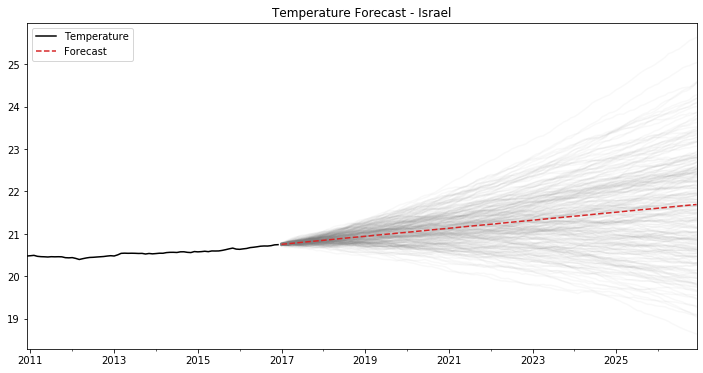

In [95]:
ax = df_10year[12*100:].plot(figsize=(12,6), title='Temperature Forecast - Israel', color='k', legend=True)

fcast[:-12*15].plot(ax=ax, label='Forecast', color='tab:red', linestyle='--', legend=True, zorder=1)
simulations[:-12*15].plot(ax=ax, alpha=0.05, color='grey', legend=False, zorder=0);

In [96]:
lower_bound = simulations.transpose().quantile(0.75)
upper_bound = simulations.transpose().quantile(0.25)

holts_df = pd.DataFrame({'Forecast': fcast, 'Lower Bound': lower_bound, 'Upper Bound': upper_bound}, index=simulations.index)

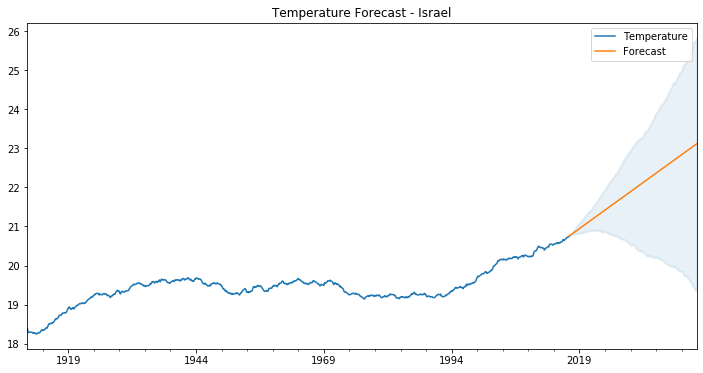

In [97]:
ax = df_10year.plot(figsize=(12,6), title='Temperature Forecast - Israel', legend=True)

holts_df['Forecast'].plot(legend=True)
plt.fill_between(holts_df.index, holts_df['Upper Bound'], holts_df['Lower Bound'], alpha=0.1, linewidth=2, color='tab:blue');

## Extensive Data Visualization:

In [98]:
from matplotlib.collections import LineCollection
from matplotlib import colors, patches
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

def plot(df_agg, df_seasonal ,idx, rule):
    
    # Setup:
    ax = plt.subplot()

    df_multi = df_seasonal.groupby([df_seasonal.index.year, df_seasonal.index.month]).sum()['Temperature']
    df = df_agg.resample(rule=rule).mean()

    temp = df['Temperature'].values
    dates_numeric = mdates.date2num(df.index)
    x_min, x_max = dates_numeric.min(), dates_numeric.max()
    y_min, y_max = df.min().min()*0.975, df.max().max()*1.025
    
    forecast_idx = df_agg.dropna(thresh=2).index.min() - pd.DateOffset(months=1)
    non_fcast_len = len(df.loc[:forecast_idx])
    
    
    # Background Image:
    img = np.fliplr(plt.imread("global-warming.jpg"))
    ax.imshow(img[:, :1800, 2], extent=[x_min, x_max, y_min, y_max], cmap='gray', alpha=0.5)
    ax.imshow(img[:, :1800, :], extent=[x_min, x_max, y_min, y_max], alpha=0.15)

    aspect_adjust = (x_max - x_min)/(y_max - y_min)
    aspect_ratio = 10/15 # figsize
    plt.gca().set_aspect(aspect_adjust * aspect_ratio)


    # Main axis:
    # Forecast main line:
    ax.plot(df[non_fcast_len:non_fcast_len+idx].index, df['Temperature'][non_fcast_len:non_fcast_len+idx],
            label='Forecast', color='k', linestyle='--', linewidth=2, alpha=0.9, zorder=2)

    # Forecast confidence interval edge lines:
    ax.plot(df[:non_fcast_len+idx].index, df['Upper Bound'][:non_fcast_len+idx], color='k', linewidth=2, alpha=0.3)
    ax.plot(df[:non_fcast_len+idx].index, df['Lower Bound'][:non_fcast_len+idx], color='k', linewidth=1.25, alpha=0.5)

    # Forecast confidence interval:
    # ax.fill_between(df.index, df['Upper Bound'], df['Lower Bound'], alpha=0.1, linewidth=3, color='k')

    # vline:
    # ax.vlines(x=pd.to_datetime('2016-12-31'), ymin=y_min, ymax=y_max, color='black', linestyle=(0, (5, 3)), linewidth=1)

    
    # Bold background for MultiColor Line:
    ax.plot(df[:non_fcast_len+1].index, temp[:non_fcast_len+1], color='k', linewidth=7, alpha=0.8, zorder=0)

    # MultiColor Line:
    points = np.array([dates_numeric, temp]).transpose().reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(temp.min(), temp.max()*0.96)

    lc = LineCollection(segments[:non_fcast_len+idx-1], cmap="coolwarm", norm=norm, linewidth=3, zorder=1)
    lc.set_array(temp)
    ax.add_collection(lc)


    # MultiColor Patch:
    df_forecast = df.dropna(thresh=2)[:idx]
    x = mdates.date2num(df_forecast.index)
    y1 = df_forecast['Lower Bound'].values
    y2 = df_forecast['Upper Bound'].values
    z = df_forecast['Temperature'].values

    normalize = colors.Normalize(vmin=z.min()-1.75, vmax=z.max())
    cmap = plt.cm.get_cmap('coolwarm')

    for i in range(len(df_forecast)-1):
        y = np.linspace(y1[i], y2[i], len(df_forecast))
        yn = np.linspace(y1[i+1], y2[i+1], len(df_forecast))
        
        for j in range(len(df_forecast)-1):
            #Area Patch:
            p1 = patches.Polygon([[x[i], y[j]], 
                                [x[i+1], yn[j]], 
                                [x[i+1], yn[j+1]], 
                                [x[i], y[j+1]]],
                                color=cmap(normalize(z[j])), alpha=0.65, linewidth=0)
            ax.add_patch(p1)
            
            ## Lines Patch:
            # p2 = patches.Polygon([[x[i], y[j]], 
            #                     [x[i+1], yn[j]]],
            #                     color=cmap(normalize(z[j])), alpha=0.75, linewidth=1.5)
            # ax.add_patch(p2)


    # Custom Legend:
    ax.legend(loc=(0.009,0.8775), prop={'size': 15}, handlelength=2.75, handletextpad=0.45)
    
    custom_lines = []
    for i in np.linspace(0,0.975,10):
        custom_lines.append(Line2D([0],[0], color=cmap(i**6), lw=3))
    labels = ['']*(len(custom_lines)-1) + ['10 Year Moving Average']

    ax1 = ax.twinx()
    ax1.get_yaxis().set_visible(False)
    
    ax1.legend(custom_lines, labels, loc=2, prop={'size': 15},
               ncol=len(custom_lines), columnspacing=-1, handlelength=0.65, handletextpad=0.555)


    # Polar axis:
    ### [left, bottom, height, weight]
    ax2 = plt.axes([0.24,0.4,0.3,0.3], polar=True)

    idx = int((idx - idx%4)*2.5) #Every 4 frames index increment by +10.
    min, max = df_multi.min(), df_multi.max()

    df_multi = df_multi.loc[1900+idx:1910+idx].reset_index().groupby('level_1').mean()['Temperature']
    df_multi.index = df_multi.index.map({1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July',
                                         8:'August', 9:'September', 10:'October', 11:'November', 12:'December'})

    months = df_multi.index
    temp =  np.append(df_multi.values, df_multi.values[0])

    theta = np.linspace(0, 2*np.pi, len(temp))
    # Arrange the grid
    lines, labels = plt.thetagrids(range(0, 360, int(360/len(months))), months)
    
    linestyle = '-'
    if idx > 110:
        linestyle = '--'

    normalize = colors.Normalize(vmin=min, vmax=max)
    color = cmap(normalize(temp.mean()))

    ax2.plot(theta, temp, color='black', linewidth=1.25, linestyle=linestyle)
    ax2.fill(theta, temp, color=color, alpha=0.4)

    ax2.set_theta_direction(-1)
    ax2.set_theta_offset(np.pi/2)

    ax2.set_ylim(2,30)
    ax2.set_yticks(np.linspace(10,25,4))
    ax2.set_rlabel_position(205)

    ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}\,$°C'))
    ax2.set_title("Average Temperature \nby Month in the " + r"$\bf{" + str(1900+idx) + "s }$", fontsize=18, pad=20)
    ax2.set_facecolor('tab:grey')
    ax2.patch.set_alpha(0.1)
    ax2.yaxis.grid(True, color='k', linestyle='-', alpha=0.3)

    def realign_polar_xticks(ax, pad, labelsize):
        for theta, label in zip(ax.get_xticks(), ax.get_xticklabels()):
            theta = theta * ax.get_theta_direction() + ax.get_theta_offset()
            theta = np.pi/2 - theta
            y, x = np.cos(theta), np.sin(theta)
            if x >= 0.1:
                label.set_horizontalalignment('left')
            if x <= -0.1:
                label.set_horizontalalignment('right')
            if y >= 0.5:
                label.set_verticalalignment('bottom')
            if y <= -0.5:
                label.set_verticalalignment('top')
        
        ax.xaxis.set_tick_params(labelsize=labelsize, pad=pad)

    realign_polar_xticks(ax2, -6, 14)


    # Figure settings:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.autoscale_view()

    ax.set_title('2040 Temperature Forecast - Israel', fontsize=30, pad=15)
    ax.text(x_max*1.00075, y_max*0.9575, 'Roei Arpaly', fontsize=14, ha='center', rotation=-90)
    ax.text(x_min*1.0095, y_min*0.96, 'Data Source: World Bank; Image taken from Earth.com', fontsize=14, ha='center', color='grey')

    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}\,$°C')) #$ \,$ for small space instead of ' '.
    ax.set_ylabel('Average Yearly Temperature (°Celsius)', fontsize=20, labelpad=10)

Yes, I know...

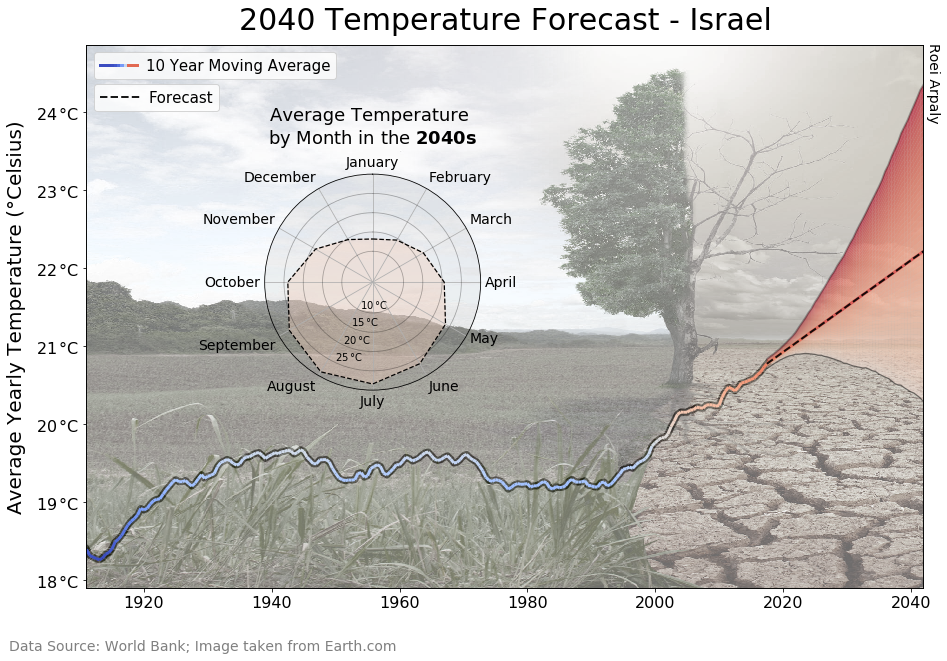

In [99]:
fig = plt.figure(figsize=(15,10))
plot(df_trend, df_seasonal, 59, '2Q');